# Rapport du projet de résolution de problème

- Paul Achard
- Julien Faure

    
- *Date : 20/01/2022*

---

In [5]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

## Problématique

Notre problématique est d'identifier un chiffre à partir d'une image.

## Objectifs

- Trouver un modèle permettant d'identifier un chiffre à partir d'une image
- Comparer différentes stratégies de solveur pour le modèle trouvé

## Analyse du dataset

Identifier un chiffre à partir d'une image est une tache qui peut s'avérer très complexe. Afin d'avoir une difficulté raisonnable et adapté au contexte de ce projet, nous avons fixé certains paramètres dans notre dataset.

- La résolution de nos images est identiques pour tout le dataset. Cette résolution est **8 pixels par 8 pixels**.
- Chaque pixel est codé sur **4 bits**.
- Les images contiennent uniquement un chiffre sans élément parasite, sans effet et sans traitement.

Nous utilisons le dataset `digits` de `seaborn`.

### Forme du dataset

In [6]:
# Import du dataset
digits = datasets.load_digits()

# Affiche le nombre d'images et leur format
print("Image Data Shape" , digits.data.shape)

# Affiche le nombre de labels
print("Label Data Shape", digits.target.shape)

Image Data Shape (1797, 64)
Label Data Shape (1797,)


Comme nous pouvons le voir ci-dessus, le dataset est composé de **1797** images labellisées.

### Répartition des images du dataset

[Text(0.5, 0, 'n° labellisé'), Text(0, 0.5, 'Occurrence')]

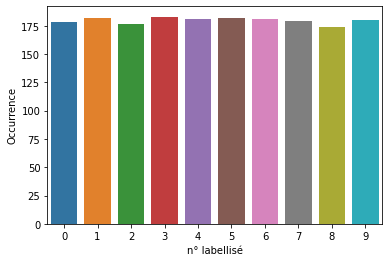

In [4]:
graphique = sns.countplot(x=digits.target)
graphique.set(xlabel="n° labellisé", ylabel = "Occurrence")

Les données labellisées sont équitablement distribuées (environ 175 par label).

### Représentation des données

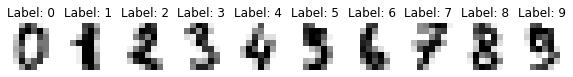

In [7]:
# Création de 10 figures de 10 par 3 pixels
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 3))

# Pour chaque figure, on affiche l'image du chiffre et son label en titre
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r)
    ax.set_title("Label: %i" % label)

### Représentation des images

In [6]:
# Affiche le tableau représentant la première image
print(digits.images[0])
print("\n Type de chaque valeur :", type(digits.images[0][0][0]))

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]

 Type de chaque valeur : <class 'numpy.float64'>


> Comme nous l'avons vu précédemment, chaque image possède une résolution de 8x8 pixels en niveaux de gris codés sur 4bits par pixel.

Dans notre programme, une image est représentée par une matrice de dimension 8x8. Chaque élément représente un pixel avec un niveau de gris codé sur 4bits (de 0 à 15). Plus la valeur est élevée, plus la couleur est foncée.

> Exemple :
* 0 : Blanc
* 15 : Noir


## Modèles

Pour résoudre notre problème, nous allons essayer les modèles suivants :
* [Modèle de regréssion logistique multiclasse](#Mod%C3%A8le-de-regr%C3%A9ssion-logistique-multiclasse)
* [Modèle de Bayes](#Mod%C3%A8le-de-Bayes)

### Mise en forme des données d'entrées

Pour commencer, nous devons redimenssionner nos données d'entrées.

Actuellement, nous avons des données sous la forme d'un tableau de matrice.

Il nous faut les mettre sous forme d'une matrice où chaque vecteur correspond aux pixels de l'image.

Donc si nous avons 1797 images, la matrice d'entrée est composée de 1797 vecteurs.

Avec une résolution de 8x8, la taille d'un vecteur est de 64 valeurs.

In [7]:
# Redimensionne la matrice en vecteur
print(digits.images[0].reshape(-1))

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


In [8]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV

# Redimenssionne le tableau de matrice en matrice
x = digits.images.reshape((len(digits.images), -1))
y = digits.target

### Jeu de test et jeu d'entraînement

Il nous faut maintenant séparer notre jeu de test et notre jeu d'entraînement du dataset.

Pour choisir la taille de notre jeu de test, il est nécessaire de faire attention à plusieurs points :
* Le temps d'entrainement de notre modèle
* La taille de notre dataset

Plus la proportion du jeu d'entraînement est faible, plus notre modèle à un niveau de variance élevé. Ainsi, on augmente les chances d'avoir de l'*over fitting*.

A contrario, plus la proportion du jeu de test est faible, plus notre modèle à un niveau de variance faible. Ainsi, on augmente les chances d'avoir de l'*under fitting*.

Le but est donc de trouver la valeur qui nous permet d'avoir le taux de variance optimal.


Pour trouver cette valeur, nous avons appliqué la procédure suivante, nous avons essayé avec plusieurs valeurs en partant de 20% jusqu'à 80% avec un pas de 5%. Nous avons déterminé que la meilleure valeur est **35%**.


> [https://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio](https://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio)

In [9]:
# séparation du dataset en données "d'apprentissage" et de test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state=0)

### Modèle de regréssion logistique multiclasse

In [18]:
# Création du modèle de régression
LR_model = LogisticRegression(verbose=False, max_iter=10000)

# Dictionnaire contenant les différents paramètres à essayer
LR_params = dict()
LR_params['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
LR_params['penalty'] = ['l2', 'none']
LR_params['C'] = [0.1, 5, 10]

# Création de nos itérations
kFold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# Création de notre modèle de validation croisée
model_cv = GridSearchCV(estimator=LR_model,
                        param_grid=LR_params,
                        scoring='accuracy',
                        cv=kFold,
                        verbose=1,
                        n_jobs=-1,
                        return_train_score=True)

# Entrainement du modèle
model_cv.fit(x_train, y_train)
# cv results
pd.set_option('display.max_columns', None)
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

Fitting 15 folds for each of 18 candidates, totalling 270 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 464, in _check_solver
    raise ValueError("penalty='none' is n

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,split12_train_score,split13_train_score,split14_train_score,mean_train_score,std_train_score
0,0.625355,0.055884,0.000564,0.000081,0.1,l2,newton-cg,"{'C': 0.1, 'penalty': 'l2', 'solver': 'newton-...",0.978632,0.965812,0.974359,0.982833,0.969957,0.974359,0.987179,0.970085,0.957082,0.982833,0.970085,0.961538,0.982906,0.969957,0.957082,0.972313,0.009115,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,1.618404,0.534624,0.000552,0.000050,0.1,l2,lbfgs,"{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.978632,0.965812,0.974359,0.982833,0.969957,0.974359,0.987179,0.970085,0.957082,0.982833,0.970085,0.961538,0.982906,0.969957,0.957082,0.972313,0.009115,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,0.088304,0.008677,0.000625,0.000065,0.1,l2,liblinear,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0.978632,0.965812,0.961538,0.969957,0.952790,0.957265,0.982906,0.952991,0.948498,0.982833,0.952991,0.961538,0.974359,0.961373,0.969957,0.964896,0.010858,10,0.994647,0.998929,0.994647,0.995722,0.996791,0.992505,0.996788,0.995717,0.995722,0.996791,0.995717,0.996788,0.995717,0.996791,0.996791,0.996004,0.001381
3,0.175708,0.020515,0.000533,0.000109,0.1,none,newton-cg,"{'C': 0.1, 'penalty': 'none', 'solver': 'newto...",0.970085,0.957265,0.965812,0.974249,0.961373,0.978632,0.982906,0.974359,0.957082,0.974249,0.965812,0.961538,0.978632,0.957082,0.935622,0.966313,0.011621,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,0.063431,0.005503,0.000558,0.000100,0.1,none,lbfgs,"{'C': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}",0.957265,0.948718,0.965812,0.944206,0.948498,0.970085,0.970085,0.965812,0.922747,0.969957,0.948718,0.957265,0.965812,0.957082,0.939914,0.955465,0.013029,13,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
5,0.000475,0.000084,0.000000,0.000000,0.1,none,liblinear,"{'C': 0.1, 'penalty': 'none', 'solver': 'libli...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.942083,0.156450,0.000588,0.000061,5,l2,newton-cg,"{'C': 5, 'penalty': 'l2', 'solver': 'newton-cg'}",0.978632,0.970085,0.965812,0.974249,0.965665,0.974359,0.978632,0.965812,0.965665,0.987124,0.957265,0.957265,0.982906,0.965665,0.948498,0.969176,0.010046,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,2.515374,0.713929,0.000547,0.000101,5,l2,lbfgs,"{'C': 5, 'penalty': 'l2', 'solver': 'lbfgs'}",0.978632,0.970085,0.965812,0.974249,0.965665,0.974359,0.978632,0.965812,0.965665,0.987124,0.957265,0.957265,0.982906,0.965665,0.948498,0.969176,0.010046,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,0.155098,0.028966,0.000627,0.000062,5,l2,liblinear,"{'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}",0.970085,0.965812

La validation croisée nous permet de determiner les paramètres optimaux pour notre modèle d'apprentissage.
Les résultats de nos tests avec de nombreux paramètres différents (dont la plupart ne sont pas présent dans l'exemple ci-dessus).
* Le **paramètre C** correspond à l'inverse de la force de régularisation des données. Plus ce paramètre est grand, plus le risque d'overfitting est grand. Une valeur de 0.1 semble être optimale.
* Le **paramètre de pénalité** permet de réduire les coefficients θ. On remarque une perte de précision si l'on n'applique pas de pénalité. La meilleure pénalité semble être la norme L2.
* Le **solveur** correspond à l'algorithme d'optimisation utilisé pour l'entrainement. Dans notre cas, lbfgs permet d'obtenir la precision la plus élevée malgré un temps d'entrainement significativement plus long que ses concurrents.

## Classification naïve bayésienne


In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import BernoulliNB

NB_model = BernoulliNB()

NB_params = {'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]}
kFold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(NB_model, NB_params, n_iter=7, scoring='accuracy', n_jobs=-1, cv=kFold, random_state=1)

# NB = RCV.fit(x_train, y_train).best_estimator_
RCV.fit(x_train, y_train)
cv_results = pd.DataFrame(RCV.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010691,0.005078,0.003557,0.002598,0,{'alpha': 0},0.837607,0.871795,0.854701,0.836910,...,0.819742,0.875536,0.833333,0.854701,0.858974,0.866953,0.871245,0.853594,0.015985,7
1,0.010525,0.001966,0.003512,0.001588,0.0001,{'alpha': 0.0001},0.841880,0.884615,0.854701,0.849785,...,0.828326,0.879828,0.854701,0.858974,0.867521,0.871245,0.884120,0.863296,0.015941,4
2,0.012197,0.006658,0.003644,0.002018,0.001,{'alpha': 0.001},0.846154,0.884615,0.854701,0.849785,...,0.836910,0.875536,0.854701,0.858974,0.867521,0.871245,0.884120,0.864722,0.014346,1
3,0.009348,0.001941,0.003311,0.001723,0.01,{'alpha': 0.01},0.850427,0.884615,0.854701,0.849785,...,0.841202,0.875536,0.858974,0.858974,0.863248,0.871245,0.884120,0.864154,0.012277,3
4,0.006661,0.001018,0.002198,0.000877,0.1,{'alpha': 0.1},0.854701,0.880342,0.854701,0.849785,...,0.841202,0.884120,0.867521,0.858974,0.854701,0.871245,0.888412,0.864442,0.012759,2
5,0.006939,0.001241,0.001852,0.000252,0.5,{'alpha': 0.5},0.850427,0.876068,0.850427,0.845494,...,0.836910,0.884120,0.871795,0.850427,0.854701,0.854077,0.875536,0.859300,0.013215,5
6,0.006219,0.001013,0.001792,0.000311,1.0,{'alpha': 1.0},0.850427,0.871795,0.850427,0.841202,...,0.832618,0.879828,0.871795,0.841880,0.854701,0.854077,0.875536,0.857587,0.013731,6


Le seul paramètre testé dans ce modèle, alpha, correspond à la force du lissage de Laplace a appliqué au modèle.
En d'autres termes, ce paramètre permet de palier la présence d'une caractéristique dans le jeu de test qui n'existe pas dans le jeu d'entrainement.
> https://towardsdatascience.com/laplace-smoothing-in-na%C3%AFve-bayes-algorithm-9c237a8bdece

Au vu des résultats, le paramètre alpha semble être optimal autour de 0.001


## Classification par arbre de décision

In [11]:
from sklearn.tree import DecisionTreeClassifier

DT_model = DecisionTreeClassifier()

DT_params = dict()
DT_params['max_depth'] = [3, None]
DT_params['min_samples_leaf'] = [1, 2, 3, 4]
DT_params['criterion'] = ["gini", "entropy"]
DT_params['splitter'] = ["best", "random"]

kFold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
RCV = RandomizedSearchCV(DT_model, DT_params, n_iter=50, scoring='accuracy', n_jobs=-1, cv=kFold, random_state=1)

DT = RCV.fit(x_train, y_train)
cv_results = pd.DataFrame(DT.cv_results_)
cv_results

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 32 is smaller than n_iter=50. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_splitter,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013529,0.002957,0.001409,0.000601,best,1,3,gini,"{'splitter': 'best', 'min_samples_leaf': 1, 'm...",0.410256,...,0.472103,0.467811,0.423077,0.452991,0.465812,0.493562,0.442060,0.452941,0.025060,31
1,0.005404,0.001093,0.001000,0.000245,random,1,3,gini,"{'splitter': 'random', 'min_samples_leaf': 1, ...",0.431624,...,0.519313,0.519313,0.495726,0.542735,0.478632,0.489270,0.480687,0.495466,0.043511,25
2,0.013018,0.002847,0.001193,0.000176,best,2,3,gini,"{'splitter': 'best', 'min_samples_leaf': 2, 'm...",0.410256,...,0.472103,0.472103,0.423077,0.452991,0.465812,0.493562,0.446352,0.453514,0.025147,29
3,0.006497,0.001823,0.001706,0.001761,random,2,3,gini,"{'splitter': 'random', 'min_samples_leaf': 2, ...",0.397436,...,0.523605,0.459227,0.482906,0.551282,0.555556,0.416309,0.493562,0.478899,0.047122,28
4,0.013622,0.002056,0.001236,0.000220,best,3,3,gini,"{'splitter': 'best', 'min_samples_leaf': 3, 'm...",0.410256,...,0.472103,0.467811,0.423077,0.452991,0.465812,0.493562,0.442060,0.452941,0.025060,31
5,0.006401,0.000354,0.001139,0.000096,random,3,3,gini,"{'splitter': 'random', 'min_samples_leaf': 3, ...",0.431624,...,0.502146,0.463519,0.410256,0.440171,0.572650,0.506438,0.506438,0.480023,0.049381,27
6,0.011536,0.002078,0.001109,0.000208,best,4,3,gini,"{'splitter': 'best', 'min_samples_leaf': 4, 'm...",0.410256,...,0.472103,0.472103,0.423077,0.452991,0.465812,0.493562,0.446352,0.453514,0.025147,29
7,0.005277,0.000813,0.000992,0.000216,random,4,3,gini,"{'splitter': 'random', 'min_samples_leaf': 4, ...",0.517094,...,0.493562,0.437768,0.461538,0.529915,0.495726,0.467811,0.480687,0.489113,0.036240,26
8,0.029272,0.005057,0.001365,0.000287,best,1,None,gini,"{'splitter': 'best', 'min_samples_leaf': 1, 'm...",0.786325,...,0.763948,0.763948,0.794872,0.854701,0.841880,0.862661,0.806867,0.818747,0.032519,5
9,0.011556,0.002577,0.001679,0.001618,random,1,None,gini,"{'splitter': 'random', 'min_samples_leaf': 1, ...",0.777778,...,0.772532,0.884120,0.799145,0.858974,0.799145,0.828326,0.802575,0.822774,0.032455,4


## Classification par boosting de gradient

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

GB_model = GradientBoostingClassifier()
GB_params = dict()
GB_params['n_estimators'] = [5, 20, 100]
GB_params['max_depth'] = [3, 5, 7]
GB_params['learning_rate'] = [0.01, 0.1, 1, 10]

kFold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(GB_model, GB_params, n_iter=36, scoring='accuracy', n_jobs=-1, cv=kFold, random_state=1)

GB = RCV.fit(x_train, y_train)
cv_results = pd.DataFrame(GB.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,0.321370,0.013692,0.001676,0.000464,5,3,0.01,"{'n_estimators': 5, 'max_depth': 3, 'learning_...",0.705128,0.777778,...,0.751073,0.798283,0.760684,0.756410,0.790598,0.755365,0.751073,0.768271,0.022569,30
1,1.230638,0.054162,0.002291,0.000401,20,3,0.01,"{'n_estimators': 20, 'max_depth': 3, 'learning...",0.756410,0.837607,...,0.811159,0.841202,0.824786,0.811966,0.867521,0.802575,0.806867,0.827339,0.026545,23
2,6.015413,0.082584,0.007531,0.001484,100,3,0.01,"{'n_estimators': 100, 'max_depth': 3, 'learnin...",0.841880,0.901709,...,0.862661,0.909871,0.876068,0.897436,0.901709,0.884120,0.841202,0.890681,0.025456,10
3,0.481627,0.021382,0.001539,0.000264,5,5,0.01,"{'n_estimators': 5, 'max_depth': 5, 'learning_...",0.743590,0.803419,...,0.793991,0.819742,0.811966,0.782051,0.837607,0.815451,0.815451,0.814796,0.025827,25
4,2.027705,0.049751,0.002997,0.000342,20,5,0.01,"{'n_estimators': 20, 'max_depth': 5, 'learning...",0.782051,0.833333,...,0.811159,0.841202,0.833333,0.846154,0.858974,0.845494,0.832618,0.842473,0.023561,20
5,9.953583,0.113209,0.009817,0.001344,100,5,0.01,"{'n_estimators': 100, 'max_depth': 5, 'learnin...",0.816239,0.867521,...,0.841202,0.884120,0.871795,0.888889,0.863248,0.892704,0.871245,0.877003,0.024551,13
6,0.671573,0.033080,0.001811,0.000307,5,7,0.01,"{'n_estimators': 5, 'max_depth': 7, 'learning_...",0.760684,0.799145,...,0.789700,0.832618,0.833333,0.807692,0.846154,0.841202,0.802575,0.820488,0.024931,24
7,3.146465,0.234148,0.003923,0.001544,20,7,0.01,"{'n_estimators': 20, 'max_depth': 7, 'learning...",0.782051,0.820513,...,0.798283,0.845494,0.854701,0.829060,0.863248,0.832618,0.802575,0.835613,0.025791,21
8,16.270429,0.955499,0.015479,0.003109,100,7,0.01,"{'n_estimators': 100, 'max_depth': 7, 'learnin...",0.786325,0.833333,...,0.832618,0.854077,0.863248,0.850427,0.867521,0.866953,0.849785,0.852178,0.021681,18
9,0.294750,0.025379,0.001505,0.000131,5,3,0.1,"{'n_estimators': 5, 'max_depth': 3, 'learning_...",0.790598,0.854701,...,0.836910,0.871245,0.858974,0.871795,0.893162,0.841202,0.841202,0.858730,0.026146,15


Pour améliorer la précision de notre modèle, nous pouvons faire varrier les trois paramètes suivants :
* Le nombre d'estimation
* La profondeur maximale
* Le taux d'apprentissage

#### Le nombre d'estimation

Ce paramètre permet de jouer sur le nombre d'arbre du modèle.
Plus ce paramètre est élevé, plus le modèle est précis.

Néanmoins, une valeur trop élevé peut causer des problèmes de performance lors de l'apprentissage.

#### La profondeur maximale

Cette valeur définit la profondeur des arbres utilisé.

Il est important de choisir une profondeur adaptée à notre jeu d'entrainement au risque de faire de l'`over fitting`.

#### Le taux d'apprentissage

Il permet d'éviter l'`under fitting` et l'`over fitting`.
Un taux d'apprentissage trop élevé pourrait amener à de l'`over fitting` et donc un mauvais résultat avec le jeu de test.
A l'inverse, un taux d'apprentissage trop faible conduirait à de l'`under fitting`.

---

> Source : [https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae](https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae)

---

### Analyse des résultats



In [21]:
cv_results[["param_n_estimators","param_max_depth","param_learning_rate","mean_test_score","rank_test_score"]].sort_values("rank_test_score")

,param_n_estimators,param_max_depth,param_learning_rate,mean_test_score,rank_test_score
1,2000,3,0.1,0.961188,1
0,1000,3,0.1,0.960900,2


Le meilleur résultat semble être avec la configuration suivante :

|  Paramètre  | Valeur  |
|---|---|
| n_estimators |  100 |
| max_depth  | 3  |
|  learning_rate | 0.1  |

> Nous avons essayé d'augmenté *le nombre d'itération* mais cela a un impacte négligeable sur le résultat.

## Classification par voisin le plus proche

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

KNN_model = KNeighborsClassifier()

KNN_params = dict()
KNN_params['n_neighbors'] = [i for i in range(1, 20, 5)]
KNN_params['weights'] = ["uniform", "distance"]
KNN_params['algorithm'] = ["ball_tree", "kd_tree", "brute"]
KNN_params['leaf_size'] = [1, 10, 30]
KNN_params['p'] = [1, 2]

kFold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(KNN_model, KNN_params, n_iter=50, scoring='accuracy', n_jobs=-1, cv=kFold, random_state=1)

KNN = RCV.fit(x_train, y_train)
cv_results = pd.DataFrame(KNN.cv_results_)
cv_results


KeyboardInterrupt



## Citation :
Stephanie Glen. "Regularization: Simple Definition, L1 & L2 Penalties" From StatisticsHowTo.com: Elementary Statistics for the rest of us! https://www.statisticshowto.com/regularization/